In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import gzip
import flymovie as fm
import stadc as sc
%load_ext autoreload
%autoreload 2

In [3]:
############################################################################
def mesh_like(arr, n):
    """Make mesh grid for last n dimensions of an array
    
    Makes a meshgrid with the same shape as the last n dimensions of input
    array-like object.
    
    Args:
        arr: array-like
            Array-like object that has a shape parameter
        n: int
            Number of dimensions, from the right, for which to make meshgrid.
    
    Returns:
        meshes: list of ndarrays
            Each element of list corresponds to ordered dimension of input,
            ndarrays are corresponding meshgrids of same shape as arr.
    """
    if (n > arr.ndim):
        raise ValueError('n is larger than the dimension of the array')
    # Make vectors of linear ranges for each dimension.
    vectors = []
    for i in reversed(range(1, n+1)):
        a = np.arange(0, arr.shape[-i])
        vectors.append(list(a))
    # Make meshgrids from vectors.
    meshes = np.meshgrid(*vectors, sparse=False, indexing='ij')
    return meshes


In [66]:
mat = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_files/hic-72-div69-71/3R_21600000_22400000_2000.txt.gz')

(0.0, 5.0)

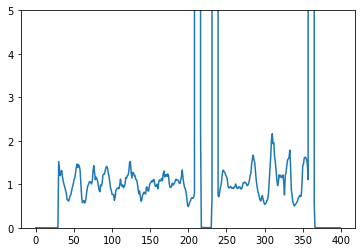

In [70]:
d = 15
y, x = mesh_like(mat, 2)
# Make a grid of distances to the diagonal, with positive values to upper right.
dist_diag = x-y
scores = np.zeros(mat.shape[0])
for n in range(d * 2, mat.shape[0] - (d * 2)):
    outter_left = mat[(x < n) & (x >= (n - (d / 2))) & (dist_diag == d)]
    outter_right = mat[(y > n) & (y <= (n + (d / 2))) & (dist_diag == d)]
    
    inner = mat[(x > n) & (y < n) & (dist_diag == d)]
    #print(np.mean(inner))
    outter = np.concatenate([outter_left, outter_right])
    score = np.mean(outter) / np.mean(inner)
    scores[n] = score

plt.plot(scores)
plt.ylim([0,5])

In [57]:
np.mean(mat)

356.4146729581737

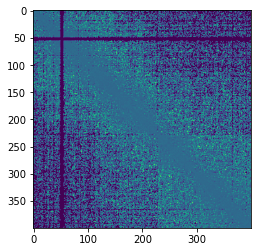

In [33]:

plt.imshow(np.log(mat + 0.001))

In [78]:
def load_track_data(trackfile_path):
        """Load genomic track data."""
        track_binsize = 500
        track_data = {}
        with gzip.open(trackfile_path, 'rt') as infile:
            for line in infile:
                items = line.split()
                (chr_, bin_, val) = items
                chr_ = re.sub('chr', '', chr_)
                
                if (chr_ not in track_data):
                    max_bin = int(4e7/ track_binsize)
                    track_data[chr_] = np.zeros(max_bin + 1000)
                bin_ = int(bin_)
                if (bin_ < len(track_data[chr_])):
                    track_data[chr_][bin_] = float(val)
        return track_data

28800 30400


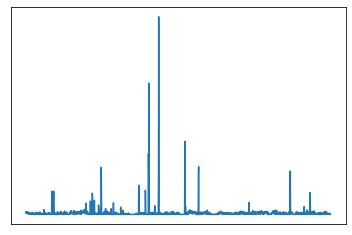

In [111]:
def plot_track(
    trackfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_tracks_reduced/GFP-GAF-1.txt.gz',
    outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-69-71/GAF_3R_14400000_15200000.png',
    chr_ = '3R',
    start = 14400000,
    end = 15200000,
    binsize = 500
    ):

    startbin = int(start / binsize)
    endbin = int(end / binsize)
    print(startbin, endbin)

    track = load_track_data(trackfile)
    plt.plot(track[chr_][startbin:(endbin+1)])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(outfile, dpi=300)

plot_track()

28800 30400


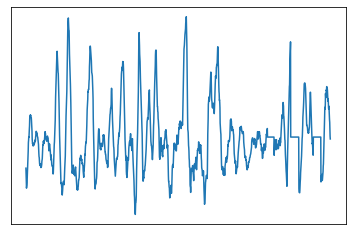

In [113]:
plot_track(trackfile='/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72/hic72_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz', outfile='/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-72/BS_3R_14400000_15200000.png')

28800 30400


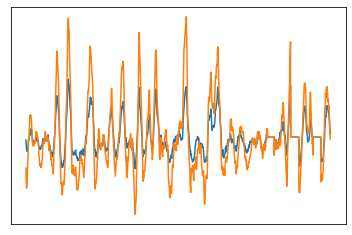

In [105]:
def plot_track2(
    trackfile1 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-69-71/hic69-71_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz',
    trackfile2 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72/hic72_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz',
    outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-69-71/GAF_3R_14400000_15200000.png',
    chr_ = '3R',
    start = 14400000,
    end = 15200000,
    binsize = 500
    ):

    startbin = int(start / binsize)
    endbin = int(end / binsize)
    print(startbin, endbin)

    track1 = load_track_data(trackfile1)
    track2 = load_track_data(trackfile2)
    plt.plot(track1[chr_][startbin:(endbin+1)])
    plt.plot(track2[chr_][startbin:(endbin+1)])
    plt.xticks([])
    plt.yticks([])
    #plt.savefig(outfile, dpi=300)

plot_track2()

In [141]:
from sklearn.decomposition import PCA

def norm_hc(mat):
    mat2 = mat.copy()
    mat2 = mat2 / (mat.mean(axis=0) + 1) * 1000
    mat2 = mat2.T
    mat2 = mat2 / (mat.mean(axis=1) + 1) * 1000
    mat2 = mat2.T
    return mat2

def distnorm(mat):
    x,y = fm.mesh_like(mat, 2)
    distmesh = y - x
    distmeans = np.zeros_like(mat)
    for n in range(np.max(distmesh)):
        distmean = np.mean(mat[distmesh == n])
        distmeans[distmesh == n] = distmean
        distmeans[distmesh == (-1 * n)] = distmean
    
    distmeans = distmeans + 0.001
    return (mat / distmeans) * 1000


def pca_mat(distnorm):
    cov = np.cov(distnorm)
    centered = (cov - np.mean(cov)) / np.std(cov)
    pct99 = np.percentile(centered, 99)
    pct1 = np.percentile(centered, 1)
    centered[centered > pct99] = pct99
    centered[centered < pct1] = pct1
    pca = PCA(n_components=2)
    pca.fit(centered)
    print(pca.explained_variance_ratio_)
    X = pca.transform(centered)
    return centered, X
    

def plot_comp(cov, pca, vmax=None, filename=None):
    if vmax == None:
        vmax = np.max(cov)
    fig = plt.figure(constrained_layout=True, figsize=(10,10))
    subfigs = fig.subfigures(2, 1, wspace=0.07, height_ratios=[1, 6.])
    axs0 = subfigs[0].subplots()
    axs0.plot(pca[:,0], linewidth=2)
    axs0.margins(x=0)
    axs0.set_yticklabels([])
    axs0.set_xticklabels([])
    axs0.set_xticks([])
    axs1 = subfigs[1].subplots()
    axs1.imshow(cov, vmax=vmax, aspect="auto", cmap='cividis')
    axs1.set_yticklabels([])
    axs1.margins(x=0)
    plt.tight_layout
    if filename is not None:
        plt.savefig(filename, dpi=300)

def pca_wflow(m, inverse=False, filename=None):
    d = distnorm(m)
    centered, X = pca_mat(d)
    if inverse:
        X[:,0] = -1 * X[:,0]
    plot_comp(centered, X, filename=filename)
    return centered, X

In [85]:
m_all = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72_binCounts_25kB.txt')
m_72 = norm_hc(m_all)
#fm.viewer(np.log(m_n + 1) * 200, 6)

In [86]:
m_all = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-69-71_binCounts_25kB.txt')
m_69 = norm_hc(m_all)
#fm.viewer(np.log(m_n + 1) * 200, 6)

In [135]:
fm.viewer(centered_69, 6)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'Reds', 'cividis', 'Gators', '…

[0.70079959 0.06059017]


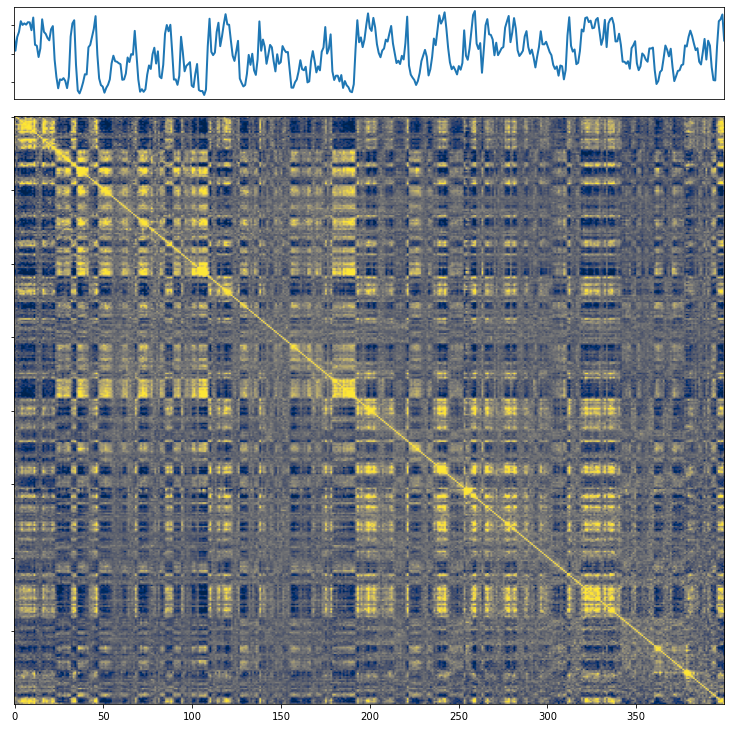

In [145]:
centered_69, X69 = pca_wflow(m_69[:400,:400], filename='/Users/michaelstadler/Desktop/temp/fig_69.png')

[0.58607679 0.10211281]


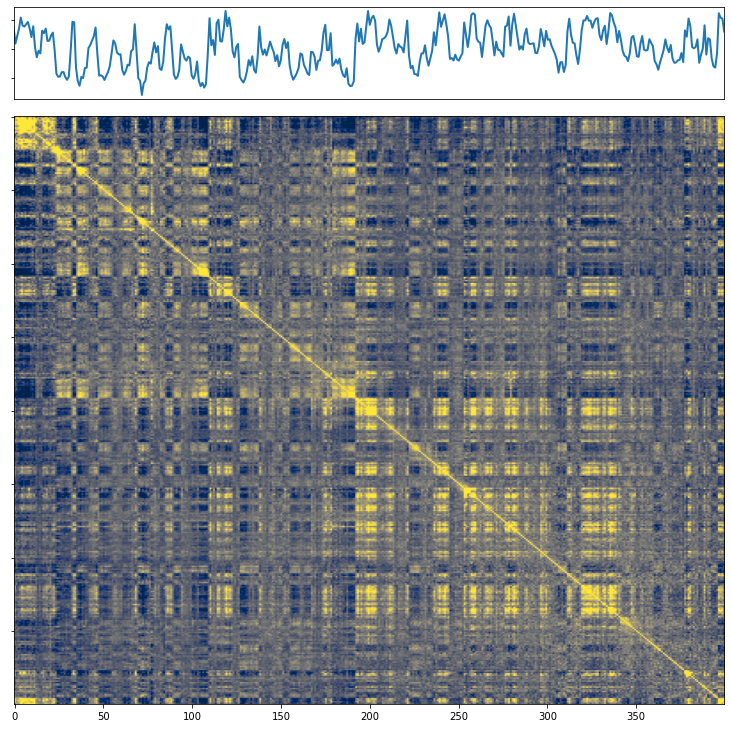

In [144]:
centered_72, X72 = pca_wflow(m_72[:400,:400], inverse=True, filename='/Users/michaelstadler/Desktop/temp/fig_72.png')

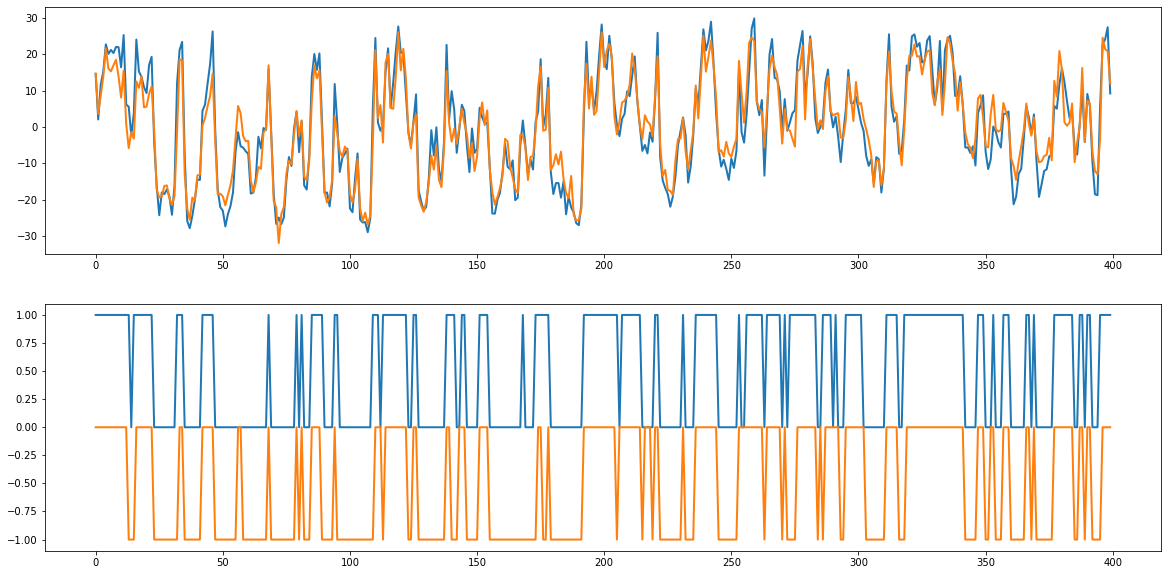

In [129]:
def plot_comp_traces(X1, X2, cut=0, col=0, inverse=False):
    comp1 = np.where(X1[:,col] > cut, 1, 0)
    comp2 = np.where(X2[:,col] > cut, 1, 0)
    if inverse:
        X2[:,col] = -1 * X2[:,col]
        comp2 = (-1 * comp2)
    comp2 -=1
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(X1[:,col], linewidth=2)
    ax[0].plot(X2[:,col], linewidth=2)
    ax[1].plot(comp1, linewidth=2)
    ax[1].plot(comp2, linewidth=2)


plot_comp_traces(X69, X72, inverse=False)
plt.savefig('/Users/michaelstadler/Desktop/temp/compare_compartment_scores.png', dpi=300)

In [153]:
centered_69, X69 = pca_wflow(m_69)

KeyboardInterrupt: 

In [152]:
start = 400
end = 800

fm.viewer([m_69[start:end, start:end], m_72[start:end, start:end]],8)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'Reds', 'cividis', 'Gators', '…

In [34]:
#m_all = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-100kb.txt_binCounts_100kB.txt')
m_all = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72_binCounts_25kB.txt')

[0.5525056  0.08269425]


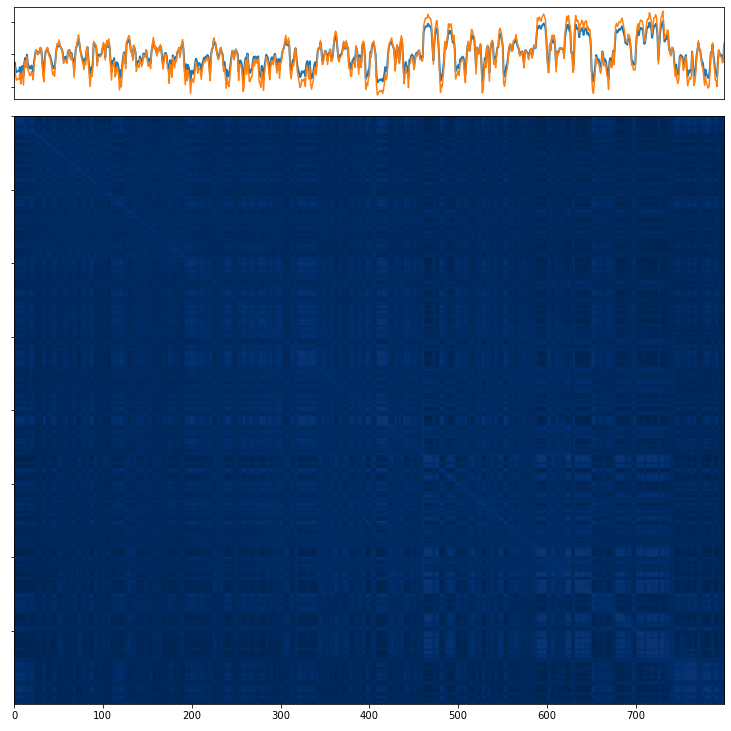

In [56]:
m = m_all[:800,:800]
m_norm = sc.norm_hic_matrix(m)
#m_norm = m.copy()
#m_norm = m_norm[:600,:600]
distnorm = sc.distnorm(m_norm)
centered, pca, X = sc.pca_matrix(distnorm)
sc.plot_compartments(centered, X)
#fm.viewer(centered * 1000, 4)

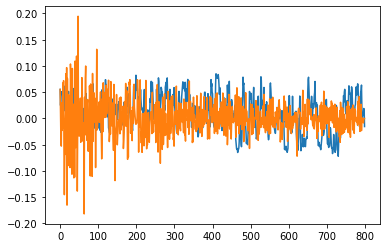

In [53]:
c = np.cov(distnorm)
e = np.linalg.eig(c)
plt.plot(e[1][:,0])
plt.plot(e[1][0,:])

In [51]:
e[1][:,0]

array([ 5.53253933e-02,  2.48697061e-02,  4.07126780e-02,  5.10081161e-02,
        5.07686525e-02,  5.00216347e-02,  5.16831425e-02,  3.93668991e-02,
        6.01766616e-02,  4.60458960e-02,  3.61386101e-02,  6.14155293e-02,
        2.49585558e-02,  1.43521511e-02,  2.75530623e-02,  5.52127249e-03,
        2.99875005e-02,  3.64602975e-02,  4.49367870e-02,  4.60681272e-02,
        3.81399685e-02,  4.08148736e-02,  5.14631567e-02,  2.04135469e-02,
        6.38275513e-03, -6.99351846e-03, -4.94515398e-03,  1.29892583e-03,
        6.73150498e-05, -5.95063345e-04, -9.61528262e-03, -9.33438877e-03,
        1.93607803e-02,  4.57473624e-02,  5.71092592e-02,  1.45637064e-02,
       -1.69595506e-03, -7.00948708e-03, -9.93162036e-03, -7.20119587e-04,
        6.11231599e-03,  8.95460062e-03,  1.93507557e-02,  3.13748893e-02,
        4.41345676e-02,  3.63649302e-02,  4.59726275e-02,  2.08773624e-02,
       -2.97834397e-03, -1.61223943e-02, -1.08705789e-02, -2.25405333e-02,
       -1.25326131e-02, -

In [86]:
m = np.zeros((90,90))
for i in range(0,90,20):
    for j in range(0,90,20):
        
        m[i:(i+10), j:(j+10)] = i + 1

fm.viewer(m, 4)

interactive(children=(Dropdown(description='Color', index=9, options=('Gators', 'gray', 'gray_r', 'Reds', 'Gre…

In [87]:
def swap(mat, start1, start2, size):
    def swap_cols(mat, start1, start2, size):
        mat_swapped = mat.copy()
        mat_swapped[:, start1:(start1 + size)] = mat[:, start2:(start2 + size)]
        mat_swapped[:, start2:(start2 + size)] = mat[:, start1:(start1 + size)]
        return mat_swapped
    if start1 >= start2:
        raise ValueError ('start2 must be after start1.')
    if size < (start2 - start2):
        raise ValueError ('Size must be greater than start2 - start1')
    # Also check if we are within matrix with start2 + size...

    # Handle matrix above and below by swapping cols.
    above = swap_cols(mat[:start1,:], start1, start2, size)
    below = swap_cols(mat[(start2 + size):,:], start1, start2, size)
    if (start1 + size) < start2:
        middle = swap_cols(mat[(start1 + size):start2, :], start1, start2, size)
    
    swapped_seg1 = swap_cols(mat[start2:(start2 + size), :], start1, start2, size)
    swapped_seg2 = swap_cols(mat[start1:(start1 + size), :], start1, start2, size)
    return np.vstack([above, swapped_seg1, middle, swapped_seg2, below])
    # Handle matrix in between by swapping cols.
    # Handle swapped regions.

fm.viewer([m, swap(m, 20, 40, 10)], 4)

interactive(children=(Dropdown(description='Color', index=9, options=('Gators', 'gray', 'gray_r', 'Reds', 'Gre…

In [ ]:
mx = 

In [102]:
mx = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-100kb.txt_binCounts_100kB.txt')
mx = np.log(mx + 0.1)
fm.viewer([m,swap(m, 200, 420, 200)],4)

interactive(children=(Dropdown(description='Color', index=9, options=('Gators', 'gray', 'gray_r', 'Reds', 'Gre…

In [103]:
vir = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/virilis_binCounts_100kB.txt')

In [104]:
vir = np.log(vir + 0.01)

In [107]:
fm.viewer(vir * 1000, 16)

interactive(children=(Dropdown(description='Color', index=9, options=('Gators', 'gray', 'gray_r', 'Reds', 'Gre…

In [127]:
import gzip
import pandas as pd
def add_read(counts, chr1, chr2):
    if chr1 not in counts:
        counts[chr1] = {}
        counts[chr1][chr2] = 1
    elif chr2 not in counts[chr1]:
        counts[chr1][chr2] = 1
    else:
        counts[chr1][chr2] += 1

counts = {}
mapfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/data/mapping/virilis_56thru59_64run1_2_Collapsed_10million.gz'
with gzip.open(mapfile, 'rt') as file:
    for line in file:
        line = line.rstrip()
        line = line.split('\t')
        chr1 = line[2]
        chr2 = line[5]
        add_read(counts, chr1, chr2)
        if chr1 != chr2:
            add_read(counts, chr2, chr1)
        
chrs = list(counts.keys())
num_chrs = len(chrs)
table = np.zeros((num_chrs, num_chrs))
for i in range(num_chrs):
    chr1 = chrs[i]
    for j in range(num_chrs):
        chr2 = chrs[j]
        if chr2 in counts[chr1]:
            table[i,j] = counts[chr1][chr2]
        
table_pd = pd.DataFrame(table, index=chrs, columns=chrs)
        



In [193]:
t = table[:300, :300]
t = sc.norm_hic_matrix(t)
t = np.log(t + 1)
t_before = t.copy()

In [205]:
n=200
for i in range(t.shape[0]-n):
#for i in range(1):
    top = np.argsort(t[i, :])[::-1]
    topn = top[1:n+1]
    t1 = t.copy()
    t1[:,(i+1):(i+n+1)] = t[:,topn]
    t1[:,topn] = t[:,(i+1):(i+n+1)]

    t2 = t1.copy()
    t2[(i+1):(i+n+1),:] = t1[topn,:]
    t2[topn,:] = t1[(i+1):(i+n+1),:]
    t = t2.copy()

In [206]:
fm.viewer([t_before * 1000, t * 1000], 4)

interactive(children=(Dropdown(description='Color', index=9, options=('Gators', 'gray', 'gray_r', 'Reds', 'Gre…